Where I attempt to solve the exercises in [section 8.5 of the d2l book](https://d2l.ai/chapter_convolutional-modern/batch-norm.html) from scratch in pytorch (without using the d2l library).

In [1]:
#| output: false
#| code-summary: Imports
try:
    import matplotlib.pyplot as plt
except:
    !pip3 install matplotlib
    import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, itertools, time, random

device = 'cpu'

## Context

The section introduces how batch norm (BN) is implemented and some of the intuitions behind its effectiveness. 

As a quick recap, batch norm layers apply the following transform to their inputs:

$$
BN(x) = \gamma \odot \frac{x-\hat \mu_B}{\hat \sigma_B} + \beta
$$

Where $\gamma$, $\beta$ are learned and $\mu_B$, $\sigma_B$ are estimated using the input's minibatch $B$.

I.e. batch norm first normalizes the input to have mean $0$ and std $1$, facilitating convergence during optimization.

However, since BN is typically applied before activation (at least traditionally), doing so will reduce the expressive power of the layer. For instance, as pointed out by the [original paper](https://arxiv.org/pdf/1502.03167), "normalizing the inputs of a sigmoid would constrain them to the linear regime of the nonlinearity". Below we plot a sigmoid and note that in the [-1, 1] range it is essentially linear.

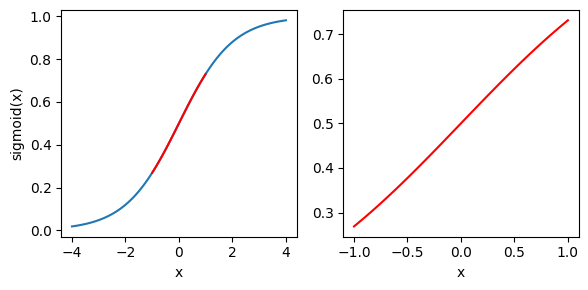

In [19]:
#| code-summary: Plot sigmoid
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
t_constrained = np.linspace(-1, 1, 100)
t_full = np.linspace(-4, 4, 100)
sigmoid = lambda t:1/(1 + np.exp(-t))
ax1.plot(t_full, sigmoid(t_full))
ax1.plot(t_constrained, sigmoid(t_constrained), c = 'r')
ax2.plot(t_constrained, sigmoid(t_constrained), c = 'r')
ax1.set_ylabel('sigmoid(x)')
ax1.set_xlabel('x')
ax2.set_xlabel('x')
f.tight_layout()

So to maintain the layer's expressive power (degrees of freedom), *"we make sure that the transformation inserted in the network can represent the identity transform"* and introduce $\gamma$ and $\beta$. So if it is optimal to leave the input unchanged, the network can learn do so by setting $\gamma = \sigma_B(x)$ and $\beta = \bar x_B$. (This part was originally confusing to me as the section only mentions "Next, we apply a scale coefficient and an offset to recover the lost degrees of freedom" - the paper provided clarification).

Finally, the second reason batch norm seems to help is the implicit regularization it provides by injecting noise into the training process. What noise? $\hat \mu_B$ and $\hat \sigma_B$ are (noisy) estimates calculated on a sample (the minibatch). Thus, the size of the minibatch $|B|$ plays an important role: too small and the estimates are too high variance; too big and the estimates become too stable (noiseless). 

Anyway, let's get to the exercises.

In [40]:
#| code-summary: Dataset and eval function
#| echo: false
training_data = datasets.MNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
testing_data = datasets.MNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())

def eval_net(net, test_loader):
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

## Q1
Should we remove the bias parameter from the fully connected layer or the convolutional layer before the batch normalization? Why?

I believe we could remove the bias parameter from both the fully connected and convolution layers if BN is applied as described in the section: right after the fully connected / convolution layer but before the activation $\phi$. Why? essentially BN is location invariant because it centers the minibatch at 0:

$$
BN_{\gamma, \beta}(x + \alpha) =  BN_{\gamma, \beta'}(x)
$$

Thus in the fully connected layer case:
$$
\boldsymbol h = \phi(BN_{\gamma, \beta}(\boldsymbol{Wx + b})) = \phi(BN_{\gamma, \beta'}(\boldsymbol{Wx}))
$$

In convolution layers we apply BN per channel, across all locations. I.e. *"each channel has its own scale and shift parameters, both of which are scalars"*. And since the convolution layer also outputs a scalar bias per channel, a similar argument applies.

But should we remove the biases? Yes. We get the same expressive power with less params.

Lets try it out empirically on MNIST by training the `BNLeNet` network defined in the section, removing bias on linear and convolution layers in turn. Although we'll not get the same learned parameters ($\beta \to \beta'$), we should get comparable performance.

In [44]:
#| code-summary: Model definition
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(module.weight)


class BNLeNet(nn.Module):
    def __init__(self, num_classes=10, removed_bias = 'linear'):
        super().__init__()
        assert removed_bias in ['linear', 'conv', 'none']
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, bias = removed_bias == 'conv'), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5, bias = removed_bias == 'conv'), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120, bias = removed_bias == 'linear'), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84, bias = removed_bias == 'linear'), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))
        
    def forward(self, x):
        return self.net(x)

In [42]:
#| code-summary: Training function

def train(net, train_loader, test_loader, num_epochs = 5, lr = 0.1, verbose = True):
    # Infer input shapes, initialize weights and move to device
    _ = net(next(iter(train_loader))[0]) # Necessary before initing weights
    net.apply(init_cnn)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr)
    
    test_accs = []
    for epoch in range(num_epochs):
        net.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        eval_acc = eval_net(net, test_loader)
        test_accs.append(eval_acc)
        if verbose: print(f'Epoch {epoch + 1}/{num_epochs}, Test acc: {eval_acc}')
        
    return test_accs

In [70]:
#| code-summary: Train and evaluate

# Set data loader seed for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

test_loader = DataLoader(testing_data, batch_size = 128, shuffle = False)

for removed_bias in ['none', 'linear', 'conv']:

    net = BNLeNet(removed_bias = removed_bias)
    torch.manual_seed(0); np.random.seed(0); random.seed(0)
    g = torch.Generator()
    g.manual_seed(0)
    train_loader = DataLoader(training_data, batch_size = 128, shuffle = True, worker_init_fn = seed_worker, generator = g)

    train(net, train_loader, test_loader, num_epochs = 10, lr = 0.1, verbose = False)
    print(f'{removed_bias} final test acc: \t{eval_net(net, test_loader)}')

/Users/emiliocantucervini/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


none final test acc: 	0.9816
linear final test acc: 	0.9863
conv final test acc: 	0.9781


Close enough.

## Q2
Compare the learning rates for LeNet with and without batch normalization.

1. Plot the increase in validation accuracy.
2. How large can you make the learning rate before the optimization fails in both cases?

In [53]:
#| code-summary: Model definitions

class LeNet(nn.Module):

    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )

    def forward(self, X):
        return self.net(X)
        
class BNLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.LazyBatchNorm1d(), nn.Sigmoid(),
            nn.LazyLinear(84), nn.LazyBatchNorm1d(), nn.Sigmoid(),
            nn.LazyLinear(num_classes))
        
    def forward(self, x):
        return self.net(x)

Let's try the range $lr \in \{1, 0.5, 0.1, 0.05\}$:

In [58]:
#| code-summary: Train and evaluate
#| echo: false

with_bn, without_bn = [], []
lrs = [1, 0.5, 0.1, 0.05]

for lr in lrs:

    net = LeNet()
    test_accs = train(net, train_loader, test_loader, num_epochs = 10, lr = lr, verbose = False)
    without_bn.append(test_accs)

    net = BNLeNet()
    test_accs = train(net, train_loader, test_loader, num_epochs = 10, lr = lr, verbose = False)
    with_bn.append(test_accs)

/Users/emiliocantucervini/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


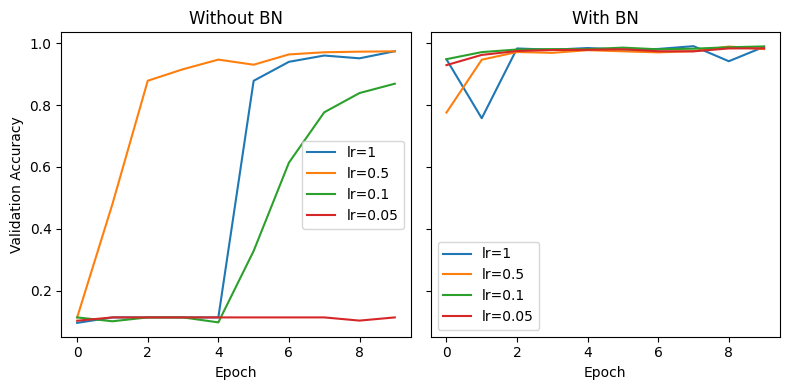

In [70]:
#| code-summary: Plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey = True)

for ax, name, results in zip([ax1, ax2], ['Without BN', 'With BN'], [without_bn, with_bn]):
    for lr, accs in zip(lrs, results):
        ax.plot(accs, label=f'lr={lr}')
        ax.legend()
        ax.set_title(f'{name}')
        ax.set_xlabel('Epoch')
ax1.set_ylabel('Validation Accuracy')
f.tight_layout()

And we observe that applying batch norm helps early training - we achive better performance earlier. And while we would probably obtain the same test accuracy given more epochs with both methods, training without BN already fails at a learning rate of $0.05$.

## Q3
Do we need batch normalization in every layer? Experiment with it.

## Q4
Implement a “lite” version of batch normalization that only removes the mean, or alternatively one that only removes the variance. How does it behave?

## Q5
Fix the parameters beta and gamma. Observe and analyze the results.

## Q6
Can you replace dropout by batch normalization? How does the behavior change?

## Q7
Research ideas: think of other normalization transforms that you can apply:

1. Can you apply the probability integral transform?

2. Can you use a full-rank covariance estimate? Why should you probably not do that?

3. Can you use other compact matrix variants (block-diagonal, low-displacement rank, Monarch, etc.)?

4. Does a sparsification compression act as a regularizer?

5. Are there other projections (e.g., convex cone, symmetry group-specific transforms) that you can use?